# Machine Learning
In this jupyter notebook, we are training a machine learning model on the data that we exported from Matlab, with our features. We split the data into the 2 recordings, so that leakage was reduced - the first recording was used for the training dataset, and the second recording was used for testing. We compared usage of a Random Forest Classifier and Support Vector Machine. Our result is that the Random Forest Classifier has a higher accuracy then the support vector machine - therefore we will use it over the Support Vector Machine.

## Importing the Data

In [84]:
import pandas as pd

In [85]:
df = pd.read_csv("ml_data.csv")
df.head()

,avg_bpm,rmssd,sdnn,gsr_avg,mean_absolute_derivative,std_gsr,stress
0,71.287129,0.046690,0.046231,9339.129032,8.688751,552.346095,0
1,88.757396,0.012000,0.008485,8033.696062,10.214207,438.878372,0
2,84.905660,0.061400,0.053454,8002.003634,7.397931,410.890078,0
3,84.905660,0.061400,0.053454,7980.096348,7.805495,386.542361,0
4,81.190798,0.063676,0.078017,7962.944878,5.007646,365.678889,0


In [86]:
import sklearn.model_selection as ms
X = df.loc[:, df.columns != "stress"]
X.head()

,avg_bpm,rmssd,sdnn,gsr_avg,mean_absolute_derivative,std_gsr
0,71.287129,0.046690,0.046231,9339.129032,8.688751,552.346095
1,88.757396,0.012000,0.008485,8033.696062,10.214207,438.878372
2,84.905660,0.061400,0.053454,8002.003634,7.397931,410.890078
3,84.905660,0.061400,0.053454,7980.096348,7.805495,386.542361
4,81.190798,0.063676,0.078017,7962.944878,5.007646,365.678889


In [87]:
Y = df.loc[:, df.columns == "stress"]
Y.head()

,stress
0,0
1,0
2,0
3,0
4,0


In [88]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# split it so that the first recording is training dataset, and 2nd recording is testing dataset
# data comes like this, all calm recordings 1 and 2, then all stress recordings 1 and 2
# We want all calm recordings 1 and all stress recordings 1 in X_train
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle

print(Counter(Y["stress"]))

calm_recording_1_length = int(1168/4)
calm_recording_2_length = int(1200/4)
stress_recording_1_length = int(1284/4)
stress_recording_2_length = int(1520/4)

# Define slice indices
calm1_start = 0
calm1_end = calm1_start + calm_recording_1_length

calm2_start = calm1_end
calm2_end = calm2_start + calm_recording_2_length

stress1_start = calm2_end
stress1_end = stress1_start + stress_recording_1_length

stress2_start = stress1_end
stress2_end = stress2_start + stress_recording_2_length

X_train = pd.concat([
    X.iloc[calm1_start:calm1_end, :],
    X.iloc[stress1_start:stress1_end, :]
])

X_test = pd.concat([
    X.iloc[calm2_start:calm2_end, :],
    X.iloc[stress2_start:stress2_end, :]
])

Y_train = pd.concat([
    Y.iloc[calm1_start:calm1_end],
    Y.iloc[stress1_start:stress1_end]
])

Y_test = pd.concat([
    Y.iloc[calm2_start:calm2_end],
    Y.iloc[stress2_start:stress2_end]
])

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

Counter({1: 699, 0: 590})
(613, 6) (676, 6)
(613, 1) (676, 1)


In [89]:
X_train.head()

,avg_bpm,rmssd,sdnn,gsr_avg,mean_absolute_derivative,std_gsr
670,77.888360,0.098752,0.119164,3359.891429,1.531244,348.858120
101,69.870845,0.088546,0.113002,4828.571973,2.764526,824.900122
131,66.683132,0.146319,0.149301,6124.757865,2.462128,396.242347
693,85.376532,0.048758,0.053750,2257.462345,1.308668,381.997600
909,72.727273,0.106623,0.103216,754.154143,2.022058,433.567687


In [90]:
Y_train.head()

,stress
670,1
101,0
131,0
693,1
909,1


## Training the SVM (Support Vector Machine)

In [91]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC()),
])

param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf'],
    'svm__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipeline, param_grid, cv=cv, verbose=0, n_jobs=-1)
grid

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svm', SVC())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'svm__C': [0.01, 0.1, ...], 'svm__class_weight': [None, 'balanced'], 'svm__gamma': ['scale', 0.1, ...], 'svm__kernel': ['rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computat

In [92]:
import numpy as np

grid.fit(X_train, np.ravel(Y_train))

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svm', SVC())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'svm__C': [0.01, 0.1, ...], 'svm__class_weight': [None, 'balanced'], 'svm__gamma': ['scale', 0.1, ...], 'svm__kernel': ['rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computat

In [93]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'svm__C': 0.01, 'svm__class_weight': None, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=0.01))])
1.0


In [94]:
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test)
print(grid.score(X_test, Y_test))
print(classification_report(Y_test, grid_predictions, zero_division=0))

0.772189349112426
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       298
           1       1.00      0.59      0.74       378

    accuracy                           0.77       676
   macro avg       0.83      0.80      0.77       676
weighted avg       0.85      0.77      0.77       676



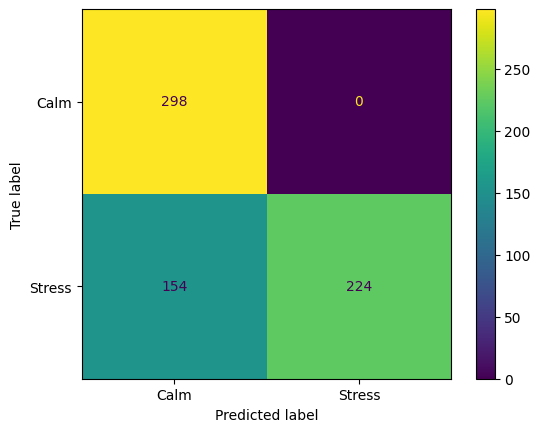

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, grid_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Calm", "Stress"])
disp.plot()
plt.show()

## Results of SVM
Our results for SVM was an accuracy 77%

## Training Logistic Regression Classifier

In [96]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [97]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'clf__max_iter'  : [1000,2500,5000]
}


In [98]:
logreg = GridSearchCV(pipeline, param_grid, verbose=0)
logreg

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__C': [0.01, 0.1, ...], 'clf__max_iter': [1000, 2500, ...], 'clf__solver': ['lbfgs', 'newton-cg', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate

In [99]:
logreg.fit(X_train, np.ravel(Y_train))

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__C': [0.01, 0.1, ...], 'clf__max_iter': [1000, 2500, ...], 'clf__solver': ['lbfgs', 'newton-cg', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate

In [100]:
logreg.score(X_test, np.ravel(Y_test))

0.8979289940828402

In [101]:
print(classification_report(Y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       298
           1       1.00      0.82      0.90       378

    accuracy                           0.90       676
   macro avg       0.91      0.91      0.90       676
weighted avg       0.92      0.90      0.90       676



In [102]:
coefficients = logreg.best_estimator_.named_steps['clf'].coef_[0]
print(coefficients)

[ 0.47824573  0.02131181 -0.49306877 -2.28480644 -1.24200688 -0.66772771]


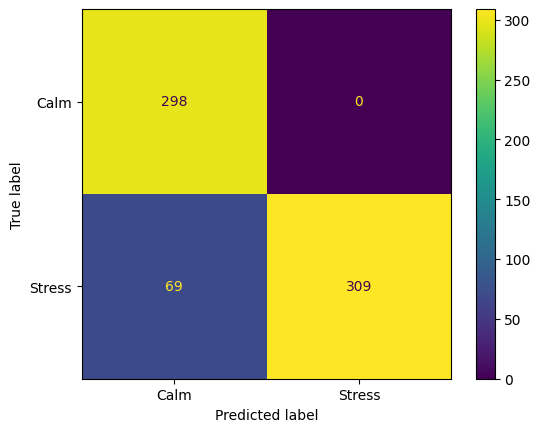

In [103]:
cm = confusion_matrix(Y_test, logreg.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Calm", "Stress"])
disp.plot()
plt.show()

## Results of Logistic Regression
Our logistic regression model has an accuracy of 90%, and its precision for stressed windows was 100% - suggesting that it only predicts stress when its extremely sure, even though it misses out on some windows.

# Results
Logistic Regression has a better accuracy at 90% compared to Support Vector Machine's 77%.
Therefore we will use a Logistic Regression Classifier over the Support Vector Machine for this dataset, due to the improved performance.

In [106]:
import joblib
joblib.dump(logreg.best_estimator_, "model.pkl")

['model.pkl']